# Introduction

In this notebook, we will motivate and implement the **k-Nearest Neighbours** (kNN) algorithm from scratch.

**Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from scipy import stats
import time

# Motivation

k-Nearest Neighbours is a powerful yet simple **classification algorithm**. It makes **predictions** by comparing new data points to its k-nearest data points and assigning a class based on the **majority class** of its neighbours. 

Note that there is **no training phase** like in other machine learning algorithms. Instead, the training set just gets saved for the prediction phase later.

<center>
<img src='https://static.javatpoint.com/tutorial/machine-learning/images/k-nearest-neighbor-algorithm-for-machine-learning2.png' width=500>
</center>    

**Choosing the value of k:**
* The algorithms performance can be **sensitive the value of k**. When k is small, the model is **sensitive to noise** and is prone to **overfitting** whereas large values of k can lead to **underfitting**, especially if there is class inbalance.
* When the number of classes is 2, **k should be an odd number** to prevent any 'tied votes' when making predictions.
* The value of k should be **bigger than the number of classes** for similar reasons. 

<center>
<img src='https://milliams.com/courses/applied_data_analysis/knn.gif' width=350>
</center>

**Metrics:**

The meaning of '**nearest**' depends on what **metric** you use. Usually, **Euclidean distance** is used but others like Manhattan and Minkowski distance can be used as well.

<center>
<img src='https://i.postimg.cc/SQLhv9Dn/1-v-At-QZb-ROu-Tdp36a-QQ8cq-BA.png' width=600>
</center>

# Data

We will apply the kNN algorithm on the famous **UCI breast cancer dataset**. This is a **binary classification** problem where the goal is to predict whether a patient has breast cancer or not using several features extracted from images.

**Load data**

In [2]:
# Load data
data = pd.read_csv('../input/breast-cancer-wisconsin-data/data.csv', index_col='id').reset_index(drop=True)
data.drop('Unnamed: 32', axis=1, inplace=True)

# Preview data
print('Dataframe shape:', data.shape)
data.head(3)

Dataframe shape: (569, 31)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


**Pre-process data**

In [3]:
# Features and labels
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

# Encode target to binary
y = (y=='M').astype('int')

**Split data**

In [4]:
# Split dataset into training and testing data (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# kNN model

We will implement the model as a **class**. Although more complicated, it allows us to write methods like 'fit' and 'predict', which provides more flexibility.

**The algorithm**

In [5]:
class kNN():
    '''k-Nearest Neighbours'''
    # Initialise
    def __init__(self, k=3, metric='euclidean', p=None):
        self.k = k
        self.metric = metric
        self.p = p
    
    # Euclidean distance (l2 norm)
    def euclidean(self, v1, v2):
        return np.sqrt(np.sum((v1-v2)**2))
    
    # Manhattan distance (l1 norm)
    def manhattan(self, v1, v2):
        return np.sum(np.abs(v1-v2))
    
    # Minkowski distance (lp norm)
    def minkowski(self, v1, v2, p=2):
        return np.sum(np.abs(v1-v2)**p)**(1/p)
        
    # Store train set
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    # Make predictions
    def predict(self, X_test):
        preds = []
        # Loop over rows in test set
        for test_row in X_test:
            nearest_neighbours = self.get_neighbours(test_row)
            majority = stats.mode(nearest_neighbours)[0][0]
            preds.append(majority)
        return np.array(preds)
    
    # Get nearest neighbours
    def get_neighbours(self, test_row):
        distances = list()
        
        # Calculate distance to all points in X_train
        for (train_row, train_class) in zip(self.X_train, self.y_train):
            if self.metric=='euclidean':
                dist = self.euclidean(train_row, test_row)
            elif self.metric=='manhattan':
                dist = self.manhattan(train_row, test_row)
            elif self.metric=='minkowski':
                dist = self.minkowski(train_row, test_row, self.p)
            else:
                raise NameError('Supported metrics are euclidean, manhattan and minkowski')
            distances.append((dist, train_class))
            
        # Sort distances
        distances.sort(key=lambda x: x[0])
        
        # Identify k nearest neighbours
        neighbours = list()
        for i in range(self.k):
            neighbours.append(distances[i][1])
            
        return neighbours

**Apply our algorithm**

In [6]:
# Function to calculate accuracy
def accuracy(preds, y_test):
    return 100 * (preds == y_test).mean()

# Apply our kNN algorithm
for metric in ['euclidean', 'manhattan']:
    clf = kNN(k=5, metric=metric)
    clf.fit(X_train.values, y_train.values)
    preds = clf.predict(X_test.values)
    print(f'Metric: {metric}, accuracy: {accuracy(preds, y_test):.3f} %')

Metric: euclidean, accuracy: 87.719 %
Metric: manhattan, accuracy: 91.228 %


**Compare to sklearn**

In [7]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train.values, y_train.values)
preds = clf.predict(X_test.values)

# Calculate test set accuracy
def accuracy(preds, y_test):
    return 100 * (preds == y_test).mean()
print(f'Sklearn accuracy: {accuracy(preds, y_test):.3f} %')

Sklearn accuracy: 87.719 %


# Experiments

**Effect of k on accuracy**

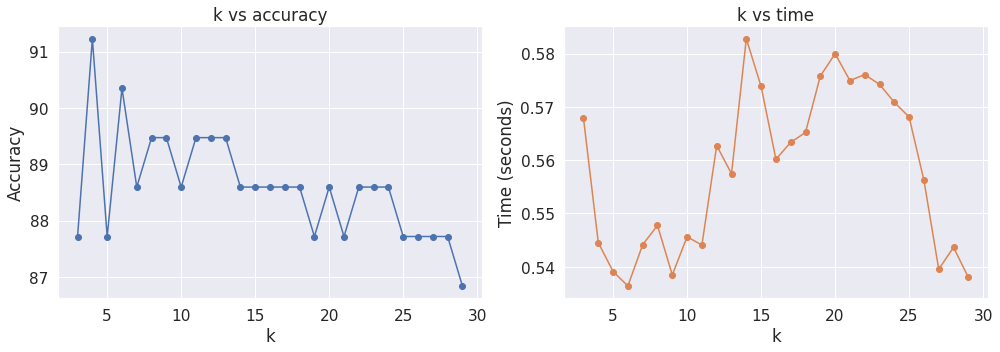

In [8]:
k_max = 30
accuracies = []
times = []

for k in range(3,k_max):
    clf = kNN(k=k, metric='euclidean')
    clf.fit(X_train.values, y_train.values)
    
    start = time.time()
    preds = clf.predict(X_test.values)
    stop = time.time()
    
    acc = accuracy(preds, y_test)
    accuracies.append(acc)
    times.append(stop-start)
    
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(range(3,k_max), accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k vs accuracy')

plt.subplot(1,2,2)
plt.plot(range(3,k_max), times, marker='o', c='C1')
plt.xlabel('k')
plt.ylabel('Time (seconds)')
plt.title('k vs time')
plt.tight_layout()
plt.show()

*Observations*

* The **accuracy is highest for small values of k** and then goes down and flattens off.
* The prediction **time is independent of k**. This is because we calculate the distance between all points regardless of the value of k. There are more efficient implementations of k-NN than this.

**Effect of p on accuracy**

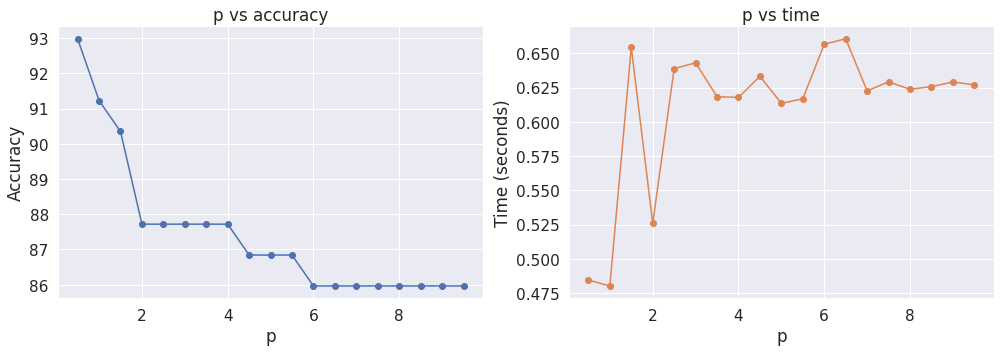

In [9]:
p_grid = np.arange(0.5,10,0.5)
accuracies = []
times = []

for p in p_grid:
    clf = kNN(k=5, metric='minkowski',p=p)
    clf.fit(X_train.values, y_train.values)
    
    start = time.time()
    preds = clf.predict(X_test.values)
    stop = time.time()
    
    acc = accuracy(preds, y_test)
    accuracies.append(acc)
    times.append(stop-start)
    
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(p_grid, accuracies, marker='o')
plt.xlabel('p')
plt.ylabel('Accuracy')
plt.title('p vs accuracy')

plt.subplot(1,2,2)
plt.plot(p_grid, times, marker='o', c='C1')
plt.xlabel('p')
plt.ylabel('Time (seconds)')
plt.title('p vs time')
plt.tight_layout()
plt.show()

*Observations*

* The **accuracy is highest for small values of p** and then flattens off sharply. 
* The **prediction time is independent of p**. This is because the metric doesn't change any significant part of the algorithm.

# References

* [Develop k-Nearest Neighbors in Python From Scratch](https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/)
* [k-NN, Logistic Regression, k-Fold CV from Scratch](https://www.kaggle.com/code/burhanykiyakoglu/k-nn-logistic-regression-k-fold-cv-from-scratch)
* [kNN from scratch in Python at 97.1%](https://www.kaggle.com/code/snshines/knn-from-scratch-in-python-at-97-1)